In [ ]:
%pip install -Uq "unstructured[all-docs]" pillow lxml
%pip install -Uq python_dotenv

In [ ]:
%pip install -Uq langchain langchain-community langchain-core
%pip install -Uq langchain-groq chromadb

%pip install -Uq ragas

In [ ]:
%pip install -qU langchain-text-splitters

In [ ]:
%pip install tiktoken

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Extract texts, tables, images using Unstructured

In [ ]:
from unstructured.partition.pdf import partition_pdf

output_path = "../"
file_path = output_path + "data/book.pdf"

chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,

    strategy="hi_res",
    languages=['ben', 'eng'],

    extract_image_block_types=['Image', 'Table'],
    extract_image_block_to_payload=True,

    chunking_strategy="by_title",
    max_characters = 10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000,
)

/Users/mymac/Downloads/RAG/10ms/rag-project/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [ ]:
# Shows what each chunk contains

chunks[4].metadata.orig_elements

In [ ]:
# images contain the base64 representation
# this is important as we need to pass the images to an llm

elements = chunks[4].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]

chunk_images[1].to_dict()

{'type': 'Image',
 'element_id': 'dbf226af-339c-4461-a6b1-f750910bb40c',
 'text': 'oF —-- ~ a',
 'metadata': {'coordinates': {'points': ((np.float64(750.0),
     np.float64(1135.0)),
    (np.float64(750.0), np.float64(1411.6666666666665)),
    (np.float64(1398.3333333333333), np.float64(1411.6666666666665)),
    (np.float64(1398.3333333333333), np.float64(1135.0))),
   'system': 'PixelSpace',
   'layout_width': 1500,
   'layout_height': 2167},
  'last_modified': '2025-07-26T15:12:19',
  'filetype': 'PPM',
  'languages': ['ben', 'eng'],
  'page_number': 13,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEVAogDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3

### Separate extracted tables, texts and images

In [6]:
texts = []

for chunk in chunks:
    if 'CompositeElement' in str(type(chunk)):
        texts.append(chunk)

len(texts)

18

In [7]:
# Get the images from CompositeElements

def get_images_base64(chunks):
    images_b64 = []

    for chunk in chunks:
        if 'CompositeElement' in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if 'Image' in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    
    return images_b64

images = get_images_base64(chunks)

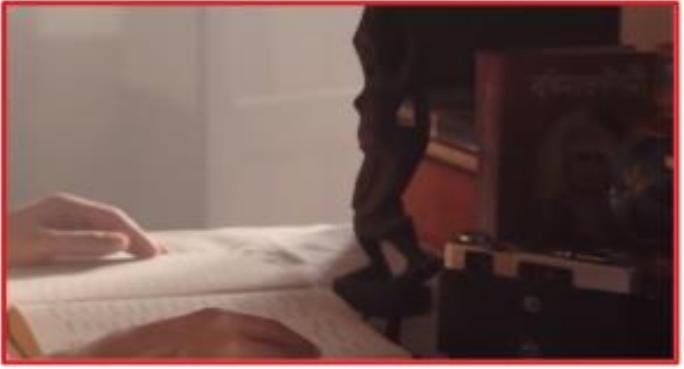

In [8]:
# what an image looks like

import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    image_data = base64.b64decode(base64_code)
    display(Image(data=image_data))

display_base64_image(images[13])

## Summarize the content

First we will chunk the extracted texts. Then we will create summary of text chunks and images and then vectorize them.

In [10]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

**N.B:** Llama-4-maverick and Llama-4-scout both are tested. Llama-4-maverick provides better results

In [11]:
llm_maverick = ChatGroq(
    temperature = 0.5,
    model = "meta-llama/llama-4-maverick-17b-128e-instruct"  
)

llm_scout = ChatGroq(
    temperature = 0.5,
    model = "meta-llama/llama-4-scout-17b-16e-instruct"  
)


### Text Chunking

**Text Chunking Strategy:**

1. Each chunk in texts is a Composite Element.
2. We will extract the texts from each chunk first.
3. Then those extracted text will be passed to RecursiveCharacterTextSplitter to split texts in a token aware setup.
4. Token aware strategy is followed because, Jina Embeddings model has a token limit of 8196.
5. Tiktoken is used to count token of each chunk

In [33]:
texts[0].to_dict()

{'type': 'CompositeElement',
 'element_id': 'c97b67f3b3929dea11a5bb221c0e8703',
 'text': 'িাাং া ১ম পত্র\n\nআল ািয রিষয়\n\nঅপরিরিতা\n\nBAA Bre Wife APIA Fars,\n\nঅনলাইন ব্যাচ সম্পর্কি ত যেককাকনা জিজ্ঞাাসা ,\n\nsaat © 16910\n\n[HSC 26] 3) wWldeisd a6\n\n"> MINUTE TG Shock\n\nর্িখনফল\n\n✓ র্নম্নর্ব্ি ব্যজক্তি হঠাৎ র্ব্িিালী হক ওঠাি ফকল সমাকি পর্িচ সংকট সম্পককি ধািণা লাভ কিকব্।\n\n✓ তৎকালীন সমাি-সভযতা ও মানব্তাি অব্মাননা সম্পককি িানকত পািকব্।\n\n✓ তৎকালীন সমাকিি পণপ্রথাি কু প্রভাব্ সম্পককি িানকত পািকব্।\n\n✓ তৎকাকল সমাকি ভদ্রকলাককি স্বভাব্বব্র্িষ্ট্য সম্পককি জ্ঞাানলাভ কিকব্।\n\n✓ নািী যকামল ঠিক, র্কন্তু দুব্িল ন - কলযাণীি িীব্নচর্িত দ্বািা প্রর্তজিত এই সতয অনুধাব্ন কিকত\n\nপািকব্।\n\n✓ মানুষ আিা র্নক যব্ঁকচ থাকক- অনুপকমি দৃষ্ট্াকন্ত মানব্িীব্কনি এই র্চিন্তন সতযদিিন সম্পককি জ্ঞাানলাভ কিকব্।\n\n&B\n\nপ্রাক-মূলযা ন\n\n১। অনুপলেি িািা কী কলি জীরিকা রনিবাহ কিলতন?\n\nক) ডাক্তার্ি\n\nখ) ওকালর্ত\n\nগ) মাস্টার্ি\n\nঘ) ব্যব্সা\n\nখ) প্রভাব্ গ) র্ব্চক্ষণতা ঘ) কূ ট ব্ুর্ি\n\n২। োোলক ভাগ্য দেিতাি প্

In [50]:
def get_texts(texts):
    texts_only = []
    for text in texts:
        # Safe check: ensure it's a dict or has .get() and 'text' key
        if isinstance(text, dict):
            if 'text' in text:
                texts_only.append(text['text'])
        elif hasattr(text, 'text'):
            texts_only.append(text.text)
    
    return "\n".join(texts_only)


In [54]:

import tiktoken
from langchain_text_splitters import RecursiveCharacterTextSplitter

encoding = tiktoken.get_encoding("cl100k_base")

def token_length(text: str) -> int:
    return len(encoding.encode(text))

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=7000,               # Max tokens per chunk
    chunk_overlap=200,             # Optional overlap for context continuity
    length_function=token_length,  # Token-aware length function
    separators=[
        "\n\n",                    # Paragraph breaks
        "\n",                      # Line breaks
        "।",                       # Bangla sentence ending
        ".",                       # English sentence ending
        "!",                       # Exclamation
        "?",                       # Question
        ";",                       # Semicolon
        " ",                       # Word level
        ""                         # Character level (last resort)
    ],
    is_separator_regex=False
)

In [55]:
chunked_texts = text_splitter.split_text(get_texts(texts))

In [56]:
chunked_texts

['িাাং া ১ম পত্র\n\nআল ািয রিষয়\n\nঅপরিরিতা\n\nBAA Bre Wife APIA Fars,\n\nঅনলাইন ব্যাচ সম্পর্কি ত যেককাকনা জিজ্ঞাাসা ,\n\nsaat © 16910\n\n[HSC 26] 3) wWldeisd a6\n\n"> MINUTE TG Shock\n\nর্িখনফল\n\n✓ র্নম্নর্ব্ি ব্যজক্তি হঠাৎ র্ব্িিালী হক ওঠাি ফকল সমাকি পর্িচ সংকট সম্পককি ধািণা লাভ কিকব্।\n\n✓ তৎকালীন সমাি-সভযতা ও মানব্তাি অব্মাননা সম্পককি িানকত পািকব্।\n\n✓ তৎকালীন সমাকিি পণপ্রথাি কু প্রভাব্ সম্পককি িানকত পািকব্।\n\n✓ তৎকাকল সমাকি ভদ্রকলাককি স্বভাব্বব্র্িষ্ট্য সম্পককি জ্ঞাানলাভ কিকব্।\n\n✓ নািী যকামল ঠিক, র্কন্তু দুব্িল ন - কলযাণীি িীব্নচর্িত দ্বািা প্রর্তজিত এই সতয অনুধাব্ন কিকত\n\nপািকব্।\n\n✓ মানুষ আিা র্নক যব্ঁকচ থাকক- অনুপকমি দৃষ্ট্াকন্ত মানব্িীব্কনি এই র্চিন্তন সতযদিিন সম্পককি জ্ঞাানলাভ কিকব্।\n\n&B\n\nপ্রাক-মূলযা ন\n\n১। অনুপলেি িািা কী কলি জীরিকা রনিবাহ কিলতন?\n\nক) ডাক্তার্ি\n\nখ) ওকালর্ত\n\nগ) মাস্টার্ি\n\nঘ) ব্যব্সা\n\nখ) প্রভাব্ গ) র্ব্চক্ষণতা ঘ) কূ ট ব্ুর্ি\n\n২। োোলক ভাগ্য দেিতাি প্রধান এলজন্ট ি াি কািণ, তাি-\n\nক) প্রর্তপজি\n\nখ) প্রভাব্\n\nগ) র্ব্চক্ষণতা\n\nঘ) কূ ট ব

### Text and tables summaries

In [57]:
# Prompt

prompt_text_summary = """
তুমি একজন বুদ্ধিমান ভাষা সহকারী, যার উদ্দেশ্য হলো একটি শিক্ষামূলক পাঠ্যবইয়ের নির্দিষ্ট অংশ (টেক্সট বা টেবিল) থেকে উচ্চ-গুণমানের, তথ্যসমৃদ্ধ সারাংশ তৈরি করা যা পরবর্তী পর্যায়ে প্রশ্নোত্তর ভিত্তিক ব্যবস্থায় কার্যকরভাবে ব্যবহৃত হতে পারে।

তোমার সারাংশ হতে হবে:
- মূল বিষয়বস্তু ও তথ্য সুনির্দিষ্টভাবে ধারণকারী  
- প্রসঙ্গ বজায় রেখে তৈরি   
- সংক্ষিপ্ত কিন্তু পরিপূর্ণ  

তুমি যেটা *করবে না*:
- ভূমিকা, উপসংহার, বা ব্যক্তিগত ব্যাখ্যা দেবে না  
- "সারাংশ:", "এই অংশে বলা হয়েছে" বা অনুরূপ বাক্যাংশ দিয়ে শুরু করবে না  
- অতিরিক্ত ব্যাখ্যামূলক বা অলংকারপূর্ণ ভাষা ব্যবহার করবে না  

উদ্দেশ্য হলো: পাঠ্যবস্তুর জ্ঞানগত কাঠামো সংরক্ষণ করে এমন একটি embedding-উপযোগী সারাংশ তৈরি করা।

এখন নিচের অংশ থেকে একটি সারাংশ তৈরি করো: {element}

"""

In [58]:
prompt = ChatPromptTemplate.from_template(prompt_text_summary)

text_summary_chain = prompt | llm_maverick | StrOutputParser()

In [ ]:
# summarize text
text_summaries = text_summary_chain.batch(chunked_texts, {"max_concurrency": 1})

text_summaries

### Image summaries

In [16]:
prompt_image_summary = ChatPromptTemplate.from_messages([
    (
        "user",
        [
            {"type": "text", "text": """
                তুমি একজন দক্ষ চিত্র বিশ্লেষক ভাষা সহকারী, যার কাজ হলো একটি চিত্র (যেমন টেবিল, ডায়াগ্রাম, চিত্রিত উদাহরণ, বা সংক্ষিপ্ত লেখা-সহ চিত্র) দেখে একটি সংক্ষিপ্ত, তথ্যবহুল সারাংশ তৈরি করা।

                তোমার সারাংশ:
                - চিত্রের মূল তথ্য ও কাঠামো ধরে রাখবে
                - ব্যাখ্যামূলক এবং তথ্যসমৃদ্ধ হবে
                - ভবিষ্যৎ প্রশ্নোত্তর ব্যবস্থায় ব্যবহারের উপযোগী হবে

                তুমি যেটা *করবে না*:
                - চিত্রটি কী তা পুনরাবৃত্তি করবে না (যেমন: "এই চিত্রে দেখা যাচ্ছে...")
                - ব্যক্তিগত মন্তব্য, উপসংহার বা অলংকার ব্যবহার করবে না
                - প্রসঙ্গের বাইরে যাবে না

                লক্ষ্য: একটি embedding-উপযোগী সারাংশ তৈরি করা যা চিত্রের জ্ঞানকে স্পষ্টভাবে সংরক্ষণ করে।
                """
            }, 
            {"type": "image_url", "image_url": {"url": "{image_url}"}}
        ]
    )
])

In [17]:
image_summary_chain = prompt_image_summary | llm_maverick | StrOutputParser()

inputs = [{"image_url": f"data:image/jpeg;base64,{img}"} for img in images]

In [18]:
image_summaries = image_summary_chain.batch(inputs, {"max_concurrency": 1})

image_summaries

['এই চিত্রটি HSC 26 ব্যাচের একটি অনলাইন কোর্সের প্রচার করছে। এতে উল্লেখিত বিষয়গুলো হলো: HSC 26 ব্যাচ, অনলাইন ব্যাচ, এবং বাংলা, ইংরেজি ও আইসিটি বিষয়।',
 'চিত্রটিতে একটি ফোন নম্বর দেখানো হয়েছে। চিত্রটি দুটি অংশে বিভক্ত, যার বাম অংশ কালো এবং ডান অংশ লাল। বাম অংশে সাদা রঙে বাংলা লিপিতে "কল করো" লেখা রয়েছে, এবং ডান অংশে একটি সাদা ফোন আইকন এবং সাদা রঙে "16910" নম্বরটি প্রদর্শিত হয়েছে।',
 'এই চিত্রটি একটি অনলাইন ব্যাচের বিজ্ঞাপন, যা HSC 26 (হায়ার সেকেন্ডারি সার্টিফিকেট পরীক্ষা 2026) এর জন্য। এখানে বাংলা, ইংরেজি এবং আইসিটি বিষয়ে অনলাইন ব্যাচের উল্লেখ রয়েছে।',
 'আমি একজন দক্ষ চিত্র বিশ্লেষক ভাষা সহকারী। আমার কাজ হলো একটি চিত্র বিশ্লেষণ করে একটি সংক্ষিপ্ত, তথ্যবহুল সারাংশ তৈরি করা। \n\nআমার সারাংশ তৈরির ক্ষেত্রে কিছু নির্দিষ্ট নিয়ম রয়েছে:\n*   চিত্রের মূল তথ্য ও কাঠামো অক্ষুণ্ণ রাখা\n*   একটি ব্যাখ্যামূলক ও তথ্যসমৃদ্ধ সারাংশ তৈরি করা\n*   ভবিষ্যৎ প্রশ্নোত্তর ব্যবস্থায় ব্যবহারের উপযোগী করে তৈরি করা\n\nআমি আমার সারাংশে যা করি না:\n*   চিত্রটি কী তা পুনরাবৃত্তি করা (যেমন: "এই চিত্রে দেখা যাচ্ছ

## Load data and summaries to vectorstore

In [19]:
import uuid
from langchain_community.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.embeddings import JinaEmbeddings

**Strategy:**

- ChromaDB is used with MultiVectorRetriever and InMemoryDocStore

In [20]:
embeddings_model = JinaEmbeddings(
    model_name="jina-embeddings-v3"
)

In [21]:
# vector store for summaries
vector_store = Chroma(
    collection_name="hsc-bangla-book",
    embedding_function=embeddings_model
)

# storage for parent documents
store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vector_store,
    docstore=store,
    id_key=id_key,
    search_type="similarity",
    search_kwargs={"k": 5}
)

/var/folders/vr/nlnm45m500scwy9b1_8y8m9w0000gn/T/ipykernel_5973/2770839166.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


### Load summaries and link to the original data

**Strategy:**

1. We will load the text_summaries and image_summaries in vector_store.
2. Original texts (Before getting the summary) will be loaded into doc_store and will be linked to text_summaries in vector_store.

In [ ]:
# add text summaries
text_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: text_ids[i], "type": "text"}) 
    for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(text_ids, texts)))

In [82]:
# add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i], "type": "image"}) 
    for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)

['3da6b357-c3c6-489e-94aa-3435b8355093',
 'ac03d37f-69c3-41c0-86ea-c5e6a33f91b3',
 '92045282-5d7d-404a-bc35-c5f2dd200a38',
 '9bed9aa0-cb35-4bc0-a89e-3e92291fd349',
 '9b23b935-ad28-4a72-8437-2bf0545a666e',
 '6b37e2a1-62f1-42be-bd8e-c2b63a0dc79b',
 '5b6fc95b-a5ee-44f8-a5bb-f525db67eb54',
 '078f6359-9e3f-41e1-8fc0-821d932477aa',
 'bf484bf5-89ff-42f7-8d3d-ef726a33628e',
 'c16d1e59-c9fd-4f42-9d93-e05aed58390c',
 '77519c72-3559-4ccd-ba9c-8cdf061860dd',
 'a6d549ad-80d3-4b14-84b7-9b484ca70b70',
 '4ac67a05-d760-4b5d-878e-f995df5faa25',
 '30e58727-e4de-4b0f-8b21-0043ca90f785',
 '35f336d3-e7ee-43ce-9c17-06e28df8e845',
 '960c03e5-807a-49f3-9ab8-62c870b1fc6c',
 '90c036f7-60f5-493b-94b4-96916c26562a',
 '93a6a087-c3fe-4ffa-af4d-34109056b6d4',
 '0dd43f5e-51c6-44a1-8593-c899d1a6fe3a',
 'd3bc7822-df77-4273-b853-2b2e41c34e13',
 '83940d63-ef04-4525-af28-b6cff8d1c324',
 '722efd05-9c1f-43e0-ad2e-a512b3b86e4b',
 'ef03cb55-6622-4234-b0d7-28a1c5353ccb',
 'fac7b23a-54e7-413b-8d21-265a9675ae9b',
 '701893b8-9b71-

## RAG Pipeline

### Short-term memory

In [ ]:
class ShortTermMemory:
    def __init__(self, max_turns=5):
        self.max_turns = max_turns
        self.history = []  # Stores (user_input, assistant_output) tuples

    def update(self, user_input: str, assistant_output: str):
        self.history.append((user_input, assistant_output))
        self.history = self.history[-self.max_turns:]

    def get_context(self):
        return "\n".join([
            f"User: {u}\nAssistant: {a}" for u, a in self.history
        ])

    def reset(self):
        self.history = []

In [ ]:
short_term_memory = ShortTermMemory(max_turns=5)

### Information Retrieval

**Strategy:**

1. MultiVectorRetriever is used with similarity search with two options provided:
   - Retrieve relevant texts summaries and image summaries from vector_store with raw_texts from doc_store
   - Retrive only relevant texts summaries and images summaries
2. Retriver will choose top-k (5) options and merge them.

In [83]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import HumanMessage
from base64 import b64decode

In [ ]:
def retrieve_context(query, use_raw_texts=False, top_k=5):
    """Retrieve context based on the query using similarity search."""
    
    retrieved_docs = retriever.vectorstore.similarity_search(query, k=top_k)
    
    final_contexts = []

    for doc in retrieved_docs:
        doc_type = doc.metadata.get("type")
        doc_id = doc.metadata.get(id_key)

        if doc_type == "text" and use_raw_texts:
            # Lookup full raw text from docstore
            raw_doc = retriever.docstore.mget([doc_id])[0]
            if raw_doc:
                final_contexts.append(raw_doc)
            else:
                # Fallback to summary if raw text not found
                final_contexts.append(doc)
        else:
            # Use the summary directly
            final_contexts.append(doc)

    return final_contexts


In [85]:
query = "রবীন্দ্রনাথ ঠাকুরের ছদ্মনাম কি ছিলো?"

In [ ]:
contexts = retrieve_context(query, top_k=5, use_raw_texts=False)

contexts

In [ ]:
contexts_with_raw_texts = retrieve_context(query, top_k=5, use_raw_texts=True)

contexts_with_raw_texts

### Response Generation

**Strategy:**

- Create_chain function will retrieve contexts based on the query and retrieval strategy.
- Then will pass it to llm using build_prompt to generate response

In [62]:
def parse_docs(docs):
    """Parse retrieved documents into text and image content"""
    text_content = ""
    image_summaries = []
    
    for doc in docs:
        doc_type = doc.metadata.get("type")
        if doc_type == "text":
            text_content += doc.page_content + "\n\n"
        elif doc_type == "image":
            image_summaries.append(doc.page_content)
    
    return {
        "text_content": text_content.strip(),
        "image_summaries": image_summaries
    }

def build_prompt(kwargs):
    context = kwargs["context"]
    user_question = kwargs["question"]

    # Combine text content and image summaries
    context_text = context["text_content"]
    
    if context["image_summaries"]:
        context_text += "\n\nছবি সংক্রান্ত তথ্য:\n"
        for i, img_summary in enumerate(context["image_summaries"], 1):
            context_text += f"{i}. {img_summary}\n"
    
    memory_context = short_term_memory.get_context()

    prompt_template = f"""
        তুমি একজন সহায়ক এবং দ্বিভাষিক ভাষা সহকারী, যার কাজ হলো শুধুমাত্র নিচের প্রসঙ্গ ব্যবহার করে ব্যবহারকারীর প্রশ্নের উত্তর দেওয়া। প্রসঙ্গের মধ্যে টেক্সট, টেবিল, ও ছবি থেকে তথ্য থাকতে পারে।

        নির্দেশনা:
        - নিচের প্রসঙ্গ ব্যবহার করে প্রশ্নের উত্তর দেবে।
        - প্রশ্নের উত্তর সংক্ষিপ্ত, স্পষ্ট এবং প্রসঙ্গ-ভিত্তিক হওয়া উচিত।
        - কল্পনাপ্রসূত বা অনুমানভিত্তিক তথ্য এড়িয়ে চলবে।
        - প্রশ্নের উত্তর দেওয়ার সময় প্রসঙ্গের তথ্য উদ্ধৃত করবে না।
        - যদি কোনও প্রশ্নের উত্তর খুঁজে না পাও, তবে {context_text} পড়ে, আউটসাইড নলেজ এ সার্চ করে সঠিক তথ্য খুঁজে, নিজের reasoning ব্যবহার করে বাইরে থেকে সঠিক প্রসঙ্গ খুঁজে উত্তর দেবে।
        - কোনো preamble বা অতিরিক্ত ব্যাখ্যা ছাড়া সরাসরি প্রশ্নের উত্তর দেবে এবং Outside knowledge ব্যবহার করলে তা উল্লেখ করে দেবে।

        --- প্রসঙ্গ শুরু ---
        {context_text}
        --- প্রসঙ্গ শেষ ---

        প্রশ্ন: {user_question}
        """
    
    prompt_template = f"""
    তুমি একজন সহায়ক এবং দ্বিভাষিক ভাষা সহকারী, যার কাজ হলো শুধুমাত্র নিচের প্রসঙ্গ ব্যবহার করে ব্যবহারকারীর প্রশ্নের উত্তর দেওয়া। প্রসঙ্গের মধ্যে টেক্সট, টেবিল, ও ছবি থেকে তথ্য থাকতে পারে।

    --- প্রসঙ্গ (Long-Term Memory) ---
    {context_text}

    --- সাম্প্রতিক কথোপকথন (Short-Term Memory) ---
    {memory_context}

    প্রশ্ন / Question: {user_question}

    Instructions (English for clarity):
    - Use only the provided context (Long-Term + Short-Term Memory). Do not invent or assume.
    - Respond in the **same language** as the user's question (Bangla or English).
    - Keep the response short, clear, and grounded in the provided context.
    - Avoid hallucinated, vague, or speculative answers.
    - If you cannot find an answer to any question, then read the {context_text} and {memory_context}, search in outside knowledge to find correct information, use your own reasoning to find the correct context from outside and provide the answer.
    - Answer the question directly without any preamble or additional explanation, and if you use outside knowledge, mention that.

    """

    return ChatPromptTemplate.from_messages([
        HumanMessage(content=prompt_template)
    ])
                

In [ ]:
def create_chain(use_raw_texts=False, top_k=5):
    """Create chain with specified retrieval strategy"""
    
    def get_context_for_chain(query):
        """Wrapper function to integrate retrieve_context with the chain"""
        docs = retrieve_context(query, use_raw_texts=use_raw_texts, top_k=top_k)
        return parse_docs(docs)
    
    return (
        {
            "context": RunnableLambda(get_context_for_chain),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(build_prompt) 
        | llm_scout
        | StrOutputParser()
    )

chain = create_chain(use_raw_texts=False, top_k=5)


In [ ]:
# Long-Short Term Memory Example

questions = [
    "রবীন্দ্রনাথ ঠাকুরের ছদ্মনাম কি ছিলো?",
    "কল্যাণীর বাবা কে ছিলেন?",
    "কাকে অনুপমের ভাগ্য দেবতা বলা হয়েছে?",
    "ভানুসিংহ ঠাকুর কে ছিলেন?"
]

for q in questions:
    response = chain.invoke(q)
    short_term_memory.update(q, response)
    print(f"Q: {q}\nA: {response}\n---")

In [ ]:
response = chain.invoke(
    "কল্যাণীর বাবা কে ছিলেন?"
)

print(response)

In [ ]:
response = chain.invoke(
    "রবীন্দ্রনাথ ঠাকুরের ছদ্মনাম কি ছিলো?"
)

print(response)

## Evaluation

For evaluating the RAG system, we may use the RAGAS library.

We will evaluate based on :

1. Cosine Similarity Score (Similarity between the generated answer and the ground truth) - `Semantic Similarity`
2. Groundedness (Is the answer supported by retrieved context?) - `Response Groundness`, `Factual Correctness`, `Faithfulness`
3. Relevance (Does the system fetch the most appropriate documents?) - `Context Relevance`, `LLMContextRecall`



In [ ]:
sample_queries = [
    "রবীন্দ্রনাথ ঠাকুরের ছদ্মনাম কি ছিলো?",
    "অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?",
    "কল্যাণীর বাবা কে ছিলেন?",
    "কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?",
    "শম্ভুনাথ সেকরার হাত এ কি পরখ করতে দিয়েছিলেন?"
]

expected_responses = [
    "রবীন্দ্রনাথ ঠাকুরের ছদ্মনাম ছিলো ভানুসিংহ ঠাকুর",
    "অনুপমের ভাষায় শম্ভুনাথ কে সুপুরুষ বলা হয়েছে",
    "কল্যাণীর বাবা ছিলেন একজন ডাক্তার। তার নাম ছিলো শম্ভুনাথ সেন",
    "অনুপমের মামাকে তার ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে",
    "শম্ভুনাথ সেকরার হাত এ একজোড়া ইয়ারিং পরখ করতে দিয়েছিলেন"
]

In [ ]:
def format_docs(relevant_docs):
    return "\n".join(doc.page_content for doc in relevant_docs)

In [ ]:
from ragas import EvaluationDataset

dataset = []

for query, reference in zip(sample_queries, expected_responses):
    relevant_docs = retrieve_context(query, top_k=5, use_raw_texts=True)
    response = chain.invoke(query)
    dataset.append(
        {
            "user_input": query,
            "retrieved_contexts": [rdoc.page_content for rdoc in relevant_docs],
            "response": response,
            "reference": reference,
        }
    )

evaluation_dataset = EvaluationDataset.from_list(dataset)

In [ ]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

from ragas import evaluate
from ragas.metrics import SemanticSimilarity, LLMContextRecall, ResponseGroundedness, ContextRelevance, Faithfulness
from ragas.metrics._factual_correctness import FactualCorrectness


In [ ]:
evaluator_llm = LangchainLLMWrapper(llm_scout)
evaluator_embedding = LangchainEmbeddingsWrapper(embeddings_model)

### Similarity Check

In [ ]:
similarity_score = evaluate(
    dataset=evaluation_dataset,
    metrics=[SemanticSimilarity()],
    embeddings=evaluator_embedding,
    experiment_name="similarity_score"
)

similarity_score

### Groundness Check

In [ ]:
groundness_check = evaluate(
    dataset=evaluation_dataset,
    metrics=[ResponseGroundedness(), Faithfulness(), FactualCorrectness()],
    llm=evaluator_llm,
    experiment_name="groundness_check"
)

groundness_check

### Relevancy Check

In [ ]:
relevancy_check = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), ContextRelevance()],
    llm=evaluator_llm,
    experiment_name="relevancy_check"
)

relevancy_check